In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("glove_emg1.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,0,-1,-5,-4,3,7,3,1,0,1,2,3,4
1,0,-3,0,2,-3,1,0,0,0,1,2,3,4
2,-2,-2,-2,-3,-4,-9,-4,-2,0,1,2,3,4
3,-1,0,-4,-2,1,0,0,-1,0,1,2,3,4
4,1,3,6,1,2,-1,-1,-2,0,1,2,3,4


In [4]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [5]:
df = data.copy(deep=True)

<AxesSubplot:>

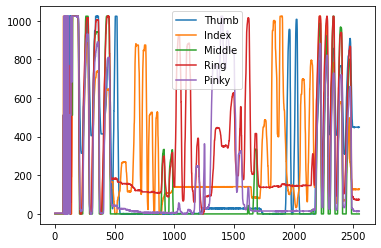

In [6]:
df[finger_names].plot()

<AxesSubplot:>

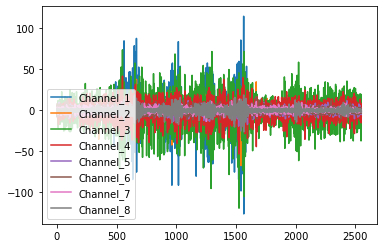

In [7]:
df[myo_cols].plot()

In [8]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Middle     Ring         0.766536
Thumb      Middle       0.747582
Channel_1  Channel_8    0.699846
Middle     Pinky        0.692025
Ring       Pinky        0.673060
Channel_3  Channel_4    0.619397
Channel_1  Channel_2    0.612738
Channel_6  Channel_7    0.592636
Index      Middle       0.588362
Channel_5  Channel_6    0.578235
dtype: float64


# Making a full hand baseline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 325.973378
Train MAE: 270.348859
Test RMSE: 317.544595
Test MAE: 264.614668


-0.042400782860461964

In [10]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,0,-1,-5,-4,3,7,3,1
1,0,-3,0,2,-3,1,0,0
2,-2,-2,-2,-3,-4,-9,-4,-2
3,-1,0,-4,-2,1,0,0,-1
4,1,3,6,1,2,-1,-1,-2
...,...,...,...,...,...,...,...,...
2545,2,8,19,8,1,1,0,1
2546,-6,-17,11,5,-4,-3,-3,-3
2547,-2,2,-38,-9,-6,-2,-3,-3
2548,4,18,14,-16,1,1,-2,0


In [11]:
y

,Thumb,Index,Middle,Ring,Pinky
0,0,1,2,3,4
1,0,1,2,3,4
2,0,1,2,3,4
3,0,1,2,3,4
4,0,1,2,3,4
...,...,...,...,...,...
2545,449,126,0,73,12
2546,449,126,0,73,12
2547,449,126,0,75,15
2548,449,126,0,75,15


# Making a baseline Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [25]:
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = abs(df[x_cols])
y = df.drop(x_cols,1)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
# Fit the scaler on the training set.
train_X = emg_scaler.fit_transform(train_X)
train_y = rel_hand_scaler.fit_transform(train_y)
# Scale the output data.
test_X = emg_scaler.transform(test_X)
test_y = rel_hand_scaler.transform(test_y)

<ipython-input-25-12b967703acd>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  y = df.drop(x_cols,1)


In [26]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='linear'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.9880 - val_loss: 0.9096
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9155 - val_loss: 0.9030
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 1.0057 - val_loss: 0.8986
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 1.0046 - val_loss: 0.8951
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9469 - val_loss: 0.8914
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9437 - val_loss: 0.8891
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9526 - val_loss: 0.8874
Epoch 8/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9484 - val_loss: 0.8859
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9459 - val_loss: 0.8843
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9266 - val_loss: 0.8858
Epoch 11/

60/60 [==============================] - 0s 3ms/step - loss: 0.7268 - val_loss: 1.0372
Epoch 84/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7176 - val_loss: 1.0554
Epoch 85/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7518 - val_loss: 1.0588
Epoch 86/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6850 - val_loss: 1.0616
Epoch 87/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6967 - val_loss: 1.0611
Epoch 88/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7125 - val_loss: 1.0735
Epoch 89/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6763 - val_loss: 1.0641
Epoch 90/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7151 - val_loss: 1.0634
Epoch 91/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6818 - val_loss: 1.0847
Epoch 92/200
60/60 [==============================] - 0s 3ms/step - loss: 0.7123 - val_loss: 1.0743
Epoch 93/200


In [28]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

20/20 [==============================] - 0s 1ms/step - loss: 1.2550


1.2549561262130737

Note that using wrist as the rel_point gives 0.10, which was a lower loss than using the palm

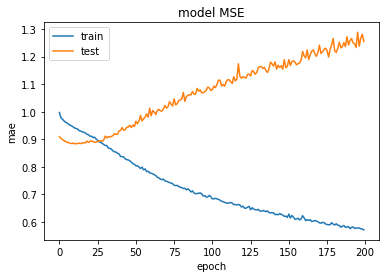

In [29]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
prediction = model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[ 1.0791408   0.807575    1.4666706   1.4773332   1.0840439 ]
 [-0.4577108  -0.70344603 -0.56625587 -0.3083717  -0.08303586]
 [ 0.6130543   0.98156846  0.8125353   0.26982483  0.37835008]
 ...
 [-0.78212154 -0.31595355 -0.58247    -0.42519993 -0.28015485]
 [ 0.18004332 -1.0253656  -0.2608794   0.14339536  0.5332544 ]
 [ 1.4053464   1.3472717   1.6541389   0.99221     1.2689172 ]]
MSE:  57106.201236975576
RMSE:  238.96903823921537
MAE:  185.1247947862767


In [31]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[ 0.2625555  -0.06977025  0.413045    0.68646103  0.8535428 ]
 [ 1.771627    1.5206892   2.0707886   1.7959018   2.11632   ]
 [-0.15629347  0.0383407  -0.1082921  -0.44533032 -0.74748486]
 ...
 [-0.1875254   0.01076347 -0.44819444 -0.6381585  -0.8680801 ]
 [ 0.93655425  0.501564    0.7255164   0.458479    0.11077188]
 [-0.49356747 -0.39159507 -0.46738178 -0.45543778 -0.3262597 ]]
MSE:  128622.448735649
RMSE:  358.63971996371095
MAE:  281.0463786960173


In [32]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Plot the predicted vs ground truth

### Save the model and the scalers

In [31]:
import joblib

model_name = "NNRel-60secs-FULL-StanScaled"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNRel-60secs-FULL-StanScaled-EMG.gz']

In [32]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred
# Five finger, 4 joints + palm, wrist. x,y,z
NUM_POINTS = (5 * 4 + 2) * 3
pred_points = scaled_pred.reshape((3, NUM_POINTS//3))

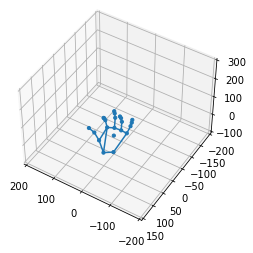

In [33]:
# Plotting pred points
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlim=(-200, 200), ylim=(-200, 150), zlim=(-100, 300))
ax.view_init(elev=45., azim=122)

points_ = np.zeros((3, NUM_POINTS))
sizes = [10]*(NUM_POINTS//3)
sizes[0] = 30
patches = ax.scatter(points_[0], points_[1], points_[2], s=10, alpha=1)

plot_points(pred_points, patches)
plot_bone_lines(pred_points, ax)

In [34]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-4.5049565e-06  1.3522451e-01  1.9394498e-01 ...  4.3251178e-01
   4.6078485e-01  4.7190204e-01]
 [-8.7510090e-04 -7.1135086e-01 -6.2075865e-01 ... -3.4064233e+00
  -3.3668852e+00 -3.1552842e+00]
 [-6.1699393e-05 -1.3594567e+00 -1.3763057e+00 ... -5.9100866e-02
  -4.8829131e-03  7.9832748e-03]
 ...
 [-5.8942282e-04  4.3737227e-01  4.4054431e-01 ...  8.8437259e-02
   4.2439986e-02  6.5242447e-02]
 [-5.8826065e-04  1.6924892e-01  1.9087942e-01 ...  2.6290509e-01
   2.7017626e-01  2.5774345e-01]
 [-6.7539624e-04 -6.0026234e-01 -6.1047447e-01 ... -5.8251113e-01
  -6.5339762e-01 -7.0003843e-01]]
MSE:  35.71878606050352
RMSE:  5.976519560789835
MAE:  3.439322011276025


Calculating error per feature, e.g. thumb error

In [68]:
leap_bone_columns = [
    "Palm_x", "Palm_y", "Palm_z",
    "Wrist_x", "Wrist_y", "Wrist_z",
    'Thumb_MCP_x', 'Thumb_MCP_y', 'Thumb_MCP_z',
    'Thumb_PIP_x', 'Thumb_PIP_y', 'Thumb_PIP_z',
    'Thumb_DIP_x', 'Thumb_DIP_y', 'Thumb_DIP_z',
    'Thumb_TIP_x', 'Thumb_TIP_y', 'Thumb_TIP_z',
    'Index_MCP_x', 'Index_MCP_y', 'Index_MCP_z',
    'Index_PIP_x', 'Index_PIP_y', 'Index_PIP_z',
    'Index_DIP_x', 'Index_DIP_y', 'Index_DIP_z',
    'Index_TIP_x', 'Index_TIP_y', 'Index_TIP_z',
    'Middle_MCP_x', 'Middle_MCP_y', 'Middle_MCP_z',
    'Middle_PIP_x', 'Middle_PIP_y', 'Middle_PIP_z',
    'Middle_DIP_x', 'Middle_DIP_y', 'Middle_DIP_z',
    'Middle_TIP_x', 'Middle_TIP_y', 'Middle_TIP_z',
    'Ring_MCP_x', 'Ring_MCP_y', 'Ring_MCP_z',
    'Ring_PIP_x', 'Ring_PIP_y', 'Ring_PIP_z',
    'Ring_DIP_x', 'Ring_DIP_y', 'Ring_DIP_z',
    'Ring_TIP_x', 'Ring_TIP_y', 'Ring_TIP_z',
    'Pinky_MCP_x', 'Pinky_MCP_y', 'Pinky_MCP_z',
    'Pinky_PIP_x', 'Pinky_PIP_y', 'Pinky_PIP_z',
    'Pinky_DIP_x', 'Pinky_DIP_y', 'Pinky_DIP_z',
    'Pinky_TIP_x', 'Pinky_TIP_y', 'Pinky_TIP_z'
    ]
len(leap_bone_columns)

66

In [67]:
pred_points = preds.reshape(740, 3, 66//3)
goal_points = goal.reshape(740, 3, 66//3)

palm_preds = pred_points[:,:,0]
palm_goals = goal_points[:,:,0]

palm_mse = mean_squared_error(palm_goals, palm_preds)
palm_mse

1.0875626856435817e-05

In [70]:
wrist_preds = pred_points[:,:,1]
wrist_goals = goal_points[:,:,1]

wrist_mse = mean_squared_error(wrist_goals, wrist_preds)
wrist_mse

10.780200176246254

In [72]:
thumb_mcp_preds = pred_points[:,:,2]
thumb_mcp_goals = goal_points[:,:,2]

thumb_mcp_mse = mean_squared_error(thumb_mcp_goals, thumb_mcp_preds)
thumb_mcp_mse

15.271220099048984

In [82]:
finger_bones = ['metacarpals', 'proximal', 'intermediate', 'distal']
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

feats = ["Palm", "Wrist"]

for finger in finger_names:
    for bone in finger_bones:
        feats.append(finger +" "+ bone)
feats

['Palm',
 'Wrist',
 'Thumb metacarpals',
 'Thumb proximal',
 'Thumb intermediate',
 'Thumb distal',
 'Index metacarpals',
 'Index proximal',
 'Index intermediate',
 'Index distal',
 'Middle metacarpals',
 'Middle proximal',
 'Middle intermediate',
 'Middle distal',
 'Ring metacarpals',
 'Ring proximal',
 'Ring intermediate',
 'Ring distal',
 'Pinky metacarpals',
 'Pinky proximal',
 'Pinky intermediate',
 'Pinky distal']

In [83]:
len(feats)

22

In [89]:
errs = []
for i in range(len(feats)):
    feat_preds = pred_points[:,:,i]
    feat_goals = goal_points[:,:,i]

    feat_mse = mean_squared_error(feat_goals, feat_preds)
    errs.append(feat_mse)
errs

[1.0875626856435817e-05,
 10.780200176246254,
 15.271220099048984,
 13.474320214318661,
 43.57190112791636,
 142.88942798792496,
 1.9141685989018764,
 15.071569206153882,
 53.241825897697105,
 109.33711284476733,
 2.4219607307248814,
 22.344041516661893,
 63.56812722527263,
 109.2310144000312,
 2.2854127839554192,
 17.02203522225584,
 46.16859129356427,
 80.04057736979594,
 2.1496048228916673,
 21.51625757334149,
 55.708007723929164,
 103.681708451581]

<BarContainer object of 22 artists>

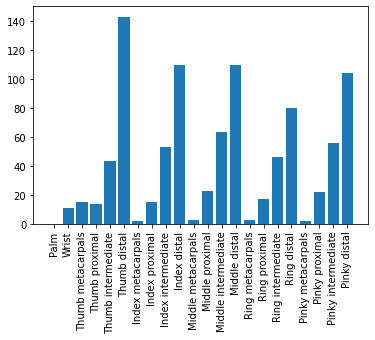

In [98]:
plt.xticks(rotation='vertical')
plt.bar(range(len(errs)),errs,tick_label=feats)

Text(0, 0.5, 'RMSE (mm)')

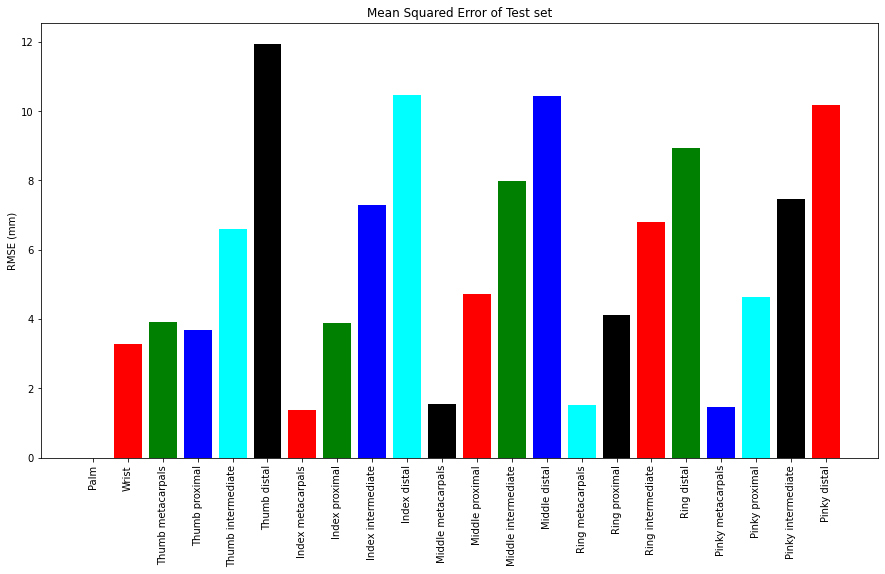

In [113]:
finger_bones = ['metacarpals', 'proximal', 'intermediate', 'distal']
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

feats = ["Palm", "Wrist"]

for finger in finger_names:
    for bone in finger_bones:
        feats.append(finger +" "+ bone)
# Calculating the error for each feature
errs = []
for i in range(len(feats)):
    feat_preds = pred_points[:,:,i]
    feat_goals = goal_points[:,:,i]

    feat_mse = mean_squared_error(feat_goals, feat_preds)**0.5
    errs.append(feat_mse)
# Plotting
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
c =['black', 'red', 'green', 'blue', 'cyan']
fig = plt.bar(range(len(errs)),errs,tick_label=feats,color=c)
plt.title("Mean Squared Error of Test set")
plt.ylabel("RMSE (mm)")

Text(0, 0.5, 'RMSE (mm)')

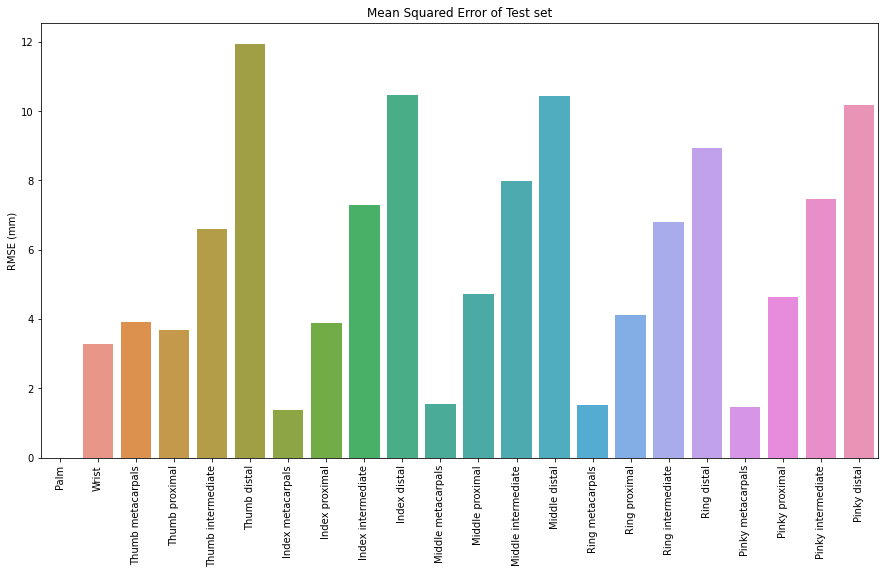

In [127]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
ax = sns.barplot(x=feats,y=errs)
plt.title("Mean Squared Error of Test set")
plt.ylabel("RMSE (mm)")

# PCA on Y

In [36]:
from sklearn.decomposition import PCA

In [42]:
leap_df = y.values.astype(float)

Y_scaled = StandardScaler().fit_transform(leap_df)


pca = PCA()
principal_components = pca.fit_transform(Y_scaled)

In [51]:
explained_var = np.round(np.cumsum(pca.explained_variance_ratio_), decimals=3)
explained_var

array([0.328, 0.504, 0.645, 0.739, 0.803, 0.852, 0.897, 0.928, 0.952,
       0.965, 0.975, 0.981, 0.985, 0.988, 0.991, 0.993, 0.994, 0.995,
       0.996, 0.997, 0.997, 0.998, 0.998, 0.999, 0.999, 0.999, 0.999,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   ])

In [52]:
explained_var[8]

0.952

In [ ]:
# Make an instance of the Model that retains 95% of the variance
pca = PCA(.95)

